## Exploratory Data Analysis

- Antibody usage by checkpoint
- Interface length and residue frequency

In [2]:
# Import statements
import numpy as numpy
import pandas as pd
import seaborn as sns #for plotting
import matplotlib.pyplot as plt
import random
import os
from scipy.stats import zscore
from collections import Counter
import requests
from Bio.PDB import PDBParser, NeighborSearch

In [3]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]


# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]


combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)


shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

## PDB IDs runterladen

In [8]:
# Um alle unique pdbs pro checkpoint geordnet runterzuladen
checkpoints = ['pd1', 'pdl1', 'ctla4', 'kir', 'lag3', 'tim3']

pdb_ids = {
    'pd1': pd1['pdb'].unique().tolist(),
    'pdl1': pdl1['pdb'].unique().tolist(),
    'ctla4': ctla4['pdb'].unique().tolist(),
    'kir': kir['pdb'].unique().tolist(),
    'lag3': lag3['pdb'].unique().tolist(),
    'tim3': tim3['pdb'].unique().tolist(),
}

#Ordner erstellen, loop über jeweiligen pdbs von checkpoint
for checkpoint in checkpoints:
    save_folder = f'structures/{checkpoint}' # Define save directory
    os.makedirs(save_folder, exist_ok=True) # make new directory with name above if doesn't exist
    for pdb_id in pdb_ids[checkpoint]:
        pdb_id = pdb_id.lower()
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        response = requests.get(url)
        if response.status_code == 200:
            with open(os.path.join(save_folder, f"{pdb_id}.pdb"), "w") as f:
                f.write(response.text)
            print(f"Downloaded: {pdb_id}.pdb")
        else:
            print(f"Failed to download: {pdb_id}.pdb (status code: {response.status_code})") 

Downloaded: 8u31.pdb
Downloaded: 8u32.pdb
Downloaded: 8gy5.pdb
Downloaded: 7wsl.pdb
Downloaded: 8as0.pdb
Downloaded: 5ggs.pdb
Downloaded: 7cgw.pdb
Downloaded: 5jxe.pdb
Downloaded: 5ggr.pdb
Downloaded: 5b8c.pdb
Downloaded: 6jjp.pdb
Downloaded: 5wt9.pdb
Downloaded: 7bxa.pdb
Downloaded: 7e9b.pdb
Downloaded: 7wvm.pdb
Downloaded: 7cu5.pdb
Downloaded: 6k0y.pdb
Downloaded: 6xkr.pdb
Downloaded: 8rpb.pdb
Downloaded: 5xj4.pdb


KeyboardInterrupt: 

## Define interface

In [ ]:
def analyze_interface_residues(pdb_path, heavy_chain, light_chain, antigen_chain, cutoff=5.0): 
    pdb_id = os.path.basename(pdb_path).replace(".pdb", "")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_path)
    model = structure[0]

    ab_chains = [heavy_chain, light_chain]
    ag_chain = antigen_chain

    ab_atoms, ag_atoms = [], [] #Liste für ab und ag Atome
    ab_residues, ag_residues = set(), set() 

    for chain in model:
        if chain.id in ab_chains:
            ab_atoms.extend(chain.get_atoms())
        elif chain.id == ag_chain:
            ag_atoms.extend(chain.get_atoms())

    ns = NeighborSearch(ab_atoms + ag_atoms)

    for atom in ab_atoms: #geht durch alle atome die im file sind
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_parent().id == ag_chain:
                ag_residues.add(res)

    for atom in ag_atoms:
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_parent().id in ab_chains:
                ab_residues.add(res)

    rows = []
    # Count frequency, residues die am häufigsten vorkommen nehmen und alle daten die innerhalb von 5A bekommen
    ab_freq = Counter(res.resname for res in ab_residues)
    ag_freq = Counter(res.resname for res in ag_residues)

    for res in ab_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antibody",
            "residue_name": res.resname,
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ab_freq[res.resname]
        })

    for res in ag_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antigen",
            "residue_name": res.resname,
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ag_freq[res.resname]
        })

    return rows

## Speichern der Daten von Residuen in csv

In [5]:
current_checkpoint = 'pd1' # wechseln 
folder_path = f"structures/{current_checkpoint}"
ckpt_ids = os.listdir(folder_path)
all_interface_rows = []

for ckpt_id in ckpt_ids:
    pdb_path = os.path.join(folder_path, ckpt_id) #structures/pd1/5b8c.pdb 
    pdb_id = ckpt_id.replace(".pdb", "") #5b8c

    try: #wenn pdbid existiert, dann gibt es die wer
        H = pd1[pd1['pdb'] == pdb_id]['Hchain'].values[0] # wechseln 
        L = pd1[pd1['pdb'] == pdb_id]['Lchain'].values[0] # wechseln
        A = pd1[pd1['pdb'] == pdb_id]['antigen_chain'].values[0] # wechseln

        rows = analyze_interface_residues(pdb_path, H, L, A) #gibt werte, die wir für die funktion brauchen 
        all_interface_rows.extend(rows) #verknüpft alle reihen

    except Exception as e: #wenn es kein pdb oder kein file
        print(f"Error with {ckpt_id}: {e}")

#Save full long-format table
df_out = pd.DataFrame(all_interface_rows) #in df umwandeln
output_folder = f"data/{current_checkpoint}" #definiert output für csv
os.makedirs(output_folder, exist_ok=True) # make Ordner, falls nciht existiert


df_out.to_csv(f"{output_folder}/{current_checkpoint}_interface_residues.csv", index=False) #erstellt ein csv (excel) file
print(f"Saved detailed data to {current_checkpoint}_interface_residues.csv")


# Create pivot summary
df_pivot = df_out.groupby(['residue_name', 'pdb_id'])['residue_name'].count().unstack(fill_value=0) #wandelt die pdb ids in spalten um und berechnet die Häufigkeit der residuen pro pdb id. unstack fill 0 setzt eine 0, wenn es nicht vorkommt
df_pivot.to_csv(f"{output_folder}/{current_checkpoint}_residue_frequencies_pivot.csv")

print(f"Saved pivot summary to {current_checkpoint}_residue_frequencies_pivot.csv")

Error with 5b8c_epitope.pse: name 'pd1' is not defined
Error with 8gy5.pdb: name 'pd1' is not defined
Error with 5b8c.pdb: name 'pd1' is not defined
Error with 5jxe_epitope.pse: name 'pd1' is not defined
Error with 7wvm.pdb: name 'pd1' is not defined
Error with 5jxe.pdb: name 'pd1' is not defined
Error with 8u32.pdb: name 'pd1' is not defined
Error with 8u31.pdb: name 'pd1' is not defined
Error with 6xkr.pdb: name 'pd1' is not defined
Error with 7bxa_epitope.pse: name 'pd1' is not defined
Error with 5ggs_epitope.pse: name 'pd1' is not defined
Error with 6k0y.pdb: name 'pd1' is not defined
Error with 8as0.pdb: name 'pd1' is not defined
Error with 7e9b.pdb: name 'pd1' is not defined
Error with 5wt9_epitope.pse: name 'pd1' is not defined
Error with 7cu5.pdb: name 'pd1' is not defined
Error with 7wsl.pdb: name 'pd1' is not defined
Error with 6xkr_epitope.pse: name 'pd1' is not defined
Error with 7wsl_epitope.pse: name 'pd1' is not defined
Error with 6k0y_epitope.pse: name 'pd1' is not defi

KeyError: 'residue_name'

## Plot heatmaps

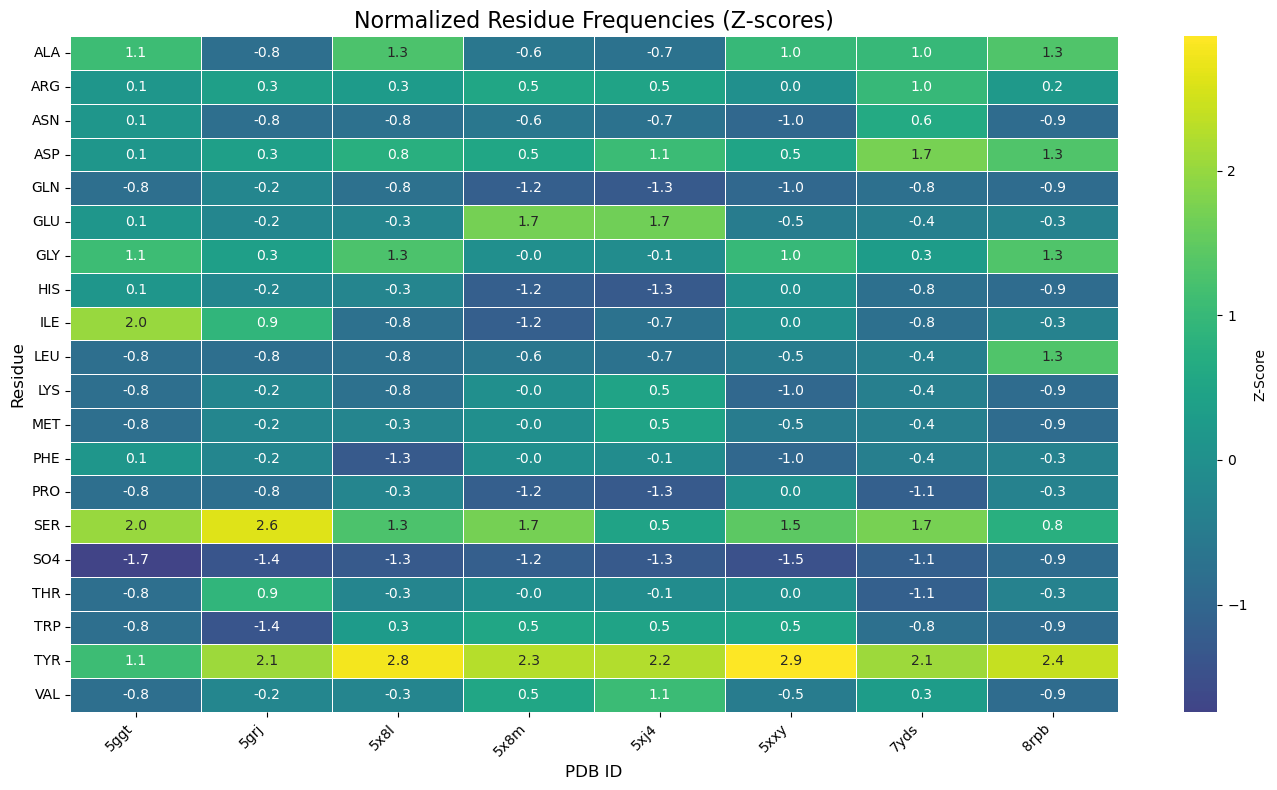

In [12]:
# Load pivoted frequency table
variable = 'pdl1'
df = pd.read_csv(f"data/{variable}/{variable}_residue_frequencies_pivot.csv", index_col=0)



# Z-score across all values
df_z = df.apply(zscore, axis=0)

plt.figure(figsize=(14, 8))

sns.heatmap(
    df_z,
    cmap="viridis", #Farbe
    center=0,
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "Z-Score"}
)

plt.title("Normalized Residue Frequencies (Z-scores)", fontsize=16)
plt.ylabel("Residue", fontsize=12)
plt.xlabel("PDB ID", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"plots/{variable}_heatmap.pdf", bbox_inches = "tight")
plt.show()

# Mean heatmap values

In [4]:
checkpoints = ['pd1', 'pdl1', 'ctla4', 'kir', 'lag3', 'tim3']
for checkpoint in checkpoints:    
    read_folder = f'data/{checkpoint}/{checkpoint}_residue_frequencies_pivot.csv'

    df= pd.read_csv(read_folder, index_col=0)
    df['mean'] = df.mean(axis = 1) #berechnet mittelwert pro zeile
    df.to_csv(read_folder, sep = ',')

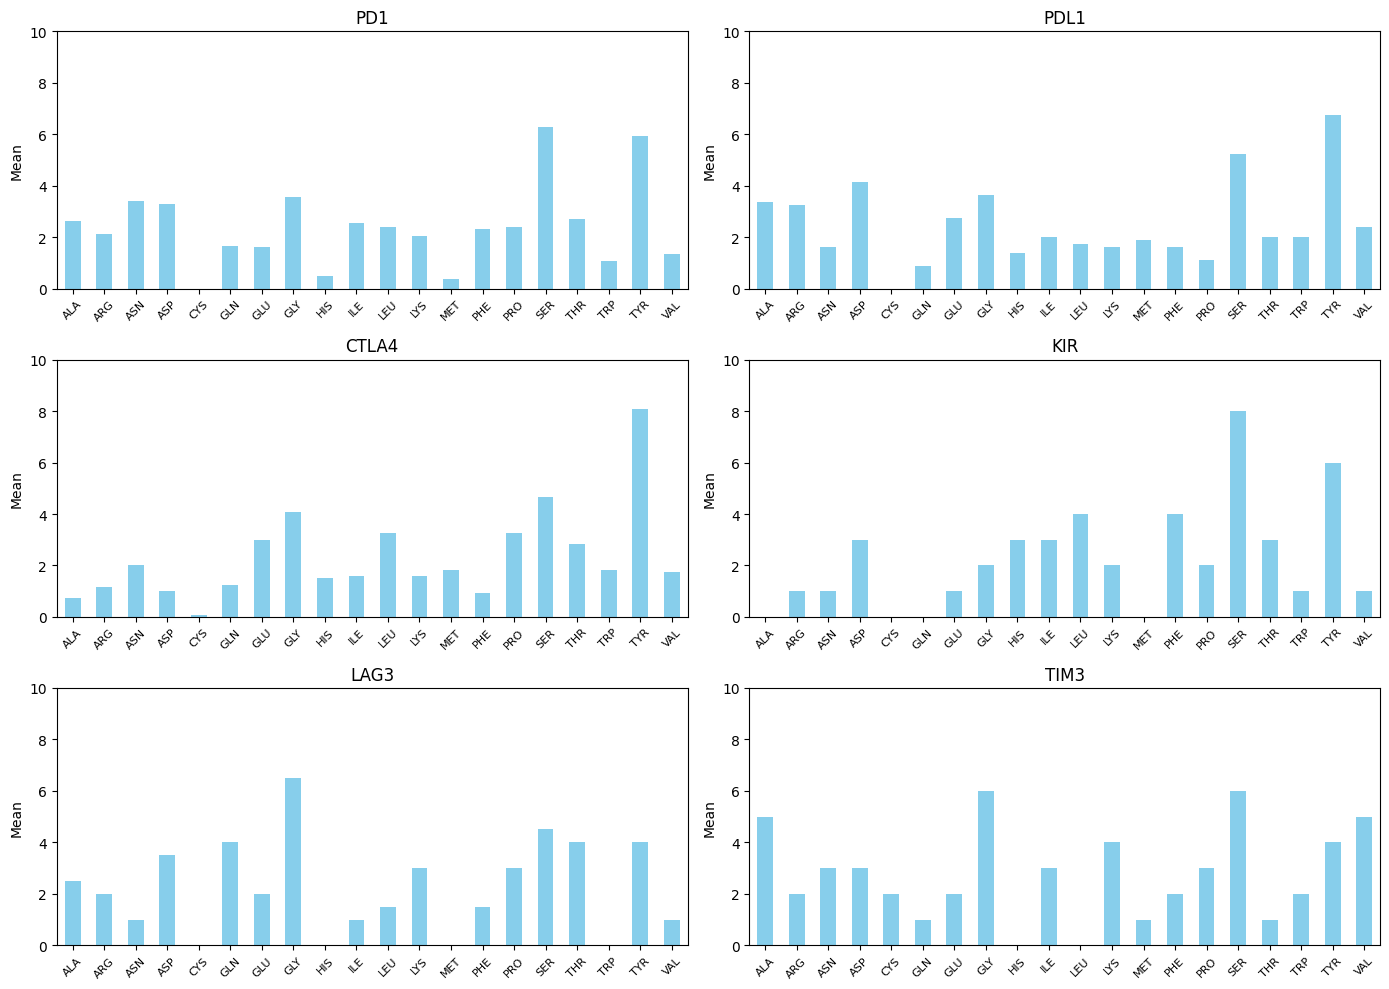

In [5]:
all_residues = [
    'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
    'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL' #Liste aller Aminosäuren, die im Plot enthalten sein sollen
]


fig, axes = plt.subplots(3, 2, figsize=(14, 10)) #Erstellt ein 3x2-Gitter von Subplots für die Visualisierung
axes = axes.flatten()


for i, cp in enumerate(checkpoints):
    file_path = f'data/{cp}/{cp}_residue_frequencies_pivot.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
        df = df.reindex(all_residues)  # Adds missing residues with NaN
        ax = axes[i]
        df['mean'].plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(f'{cp.upper()}')
        ax.set_ylim(0, 10)
        ax.set_xlabel('')
        ax.set_ylabel('Mean')
        ax.tick_params(axis='x', labelrotation=45, labelsize=8)

# Remove any unused subplots
for j in range(len(checkpoints), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig(f"plots/checkpoint_AA_freq_barplot.pdf")
plt.show()

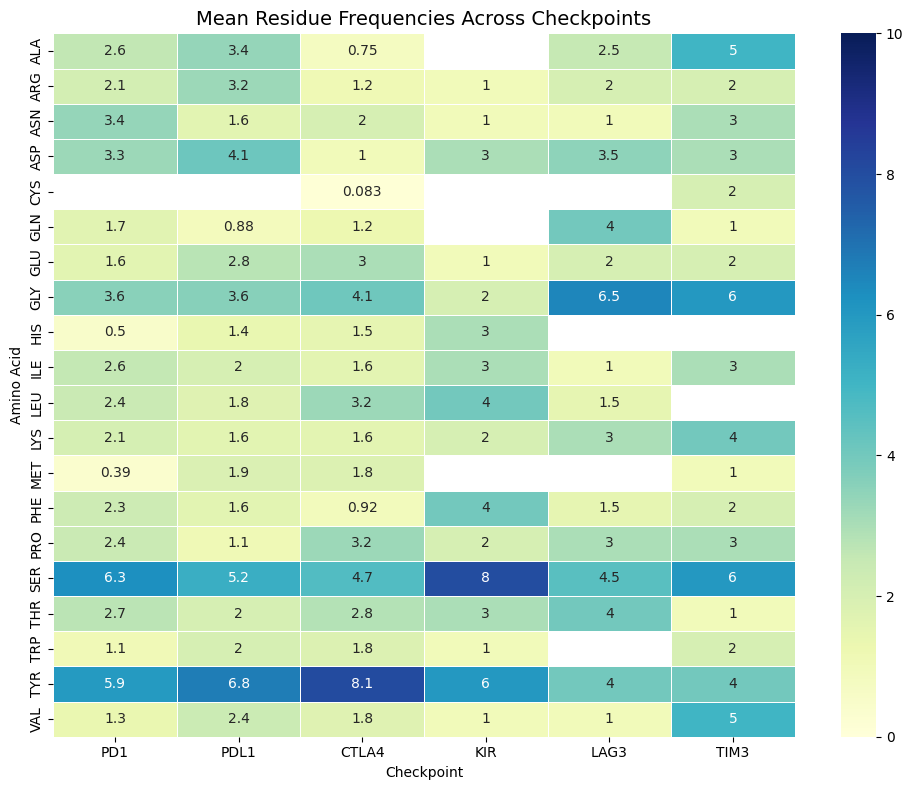

In [6]:
heatmap_data = pd.DataFrame(index=all_residues)

for cp in checkpoints:
    file_path = f'data/{cp}/{cp}_residue_frequencies_pivot.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
        df = df.reindex(all_residues)  # ensure consistent order
        heatmap_data[cp.upper()] = df['mean']

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", vmin=0, vmax=10, linewidths=0.5)
plt.title("Mean Residue Frequencies Across Checkpoints", fontsize=14)
plt.xlabel("Checkpoint")
plt.ylabel("Amino Acid")
plt.tight_layout()
# plt.savefig("plots/checkpoint_AA_freq_heatmap.pdf", dpi=300)
plt.show()


In [11]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 42.3 MB/s eta 0:00:0000:010:01
  Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import glob
import pandas as pd
import numpy as np
from Bio.PDB import PDBParser, NeighborSearch
from propy.PseudoAAC import GetPseudoAAC, _Hydrophobicity, _hydrophilicity, _residuemass
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [22]:
three_to_one = {
    'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C',
    'GLU':'E','GLN':'Q','GLY':'G','HIS':'H','ILE':'I',
    'LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P',
    'SER':'S','THR':'T','TRP':'W','TYR':'Y','VAL':'V'
}
AAP = [_Hydrophobicity, _hydrophilicity, _residuemass]

def analyze_interface_and_pseaac(pdb_path, heavy_chain, light_chain, antigen_chain, cutoff=5.0):

    lamda = 10
    weight = 0.05

    pdb_id = os.path.basename(pdb_path).replace(".pdb", "")
    parser = PDBParser(QUIET=True)
    struct = parser.get_structure(pdb_id, pdb_path)
    model = struct[0]

    ab_chains = [heavy_chain, light_chain]
    ag_chain_id = antigen_chain

    ab_atoms, ag_atoms = [], []
    ab_residues, ag_residues = set(), set()

    for chain in model:
        if chain.id in ab_chains:
            ab_atoms.extend(chain.get_atoms())
        elif chain.id == ag_chain_id:
            ag_atoms.extend(chain.get_atoms())

    ns = NeighborSearch(ab_atoms + ag_atoms)

    # Identify antigen interface residues
    for atom in ab_atoms:
        for neigh in ns.search(atom.coord, cutoff):
            res = neigh.get_parent()
            if res.get_parent().id == ag_chain_id:
                ag_residues.add(res)
    # Identify antibody interface residues
    for atom in ag_atoms:
        for neigh in ns.search(atom.coord, cutoff):
            res = neigh.get_parent()
            if res.get_parent().id in ab_chains:
                ab_residues.add(res)

    # Prepare summary rows
    rows = []
    ab_freq = Counter(res.resname for res in ab_residues)
    ag_freq = Counter(res.resname for res in ag_residues)

    for res_set, freq_dict, partner in [
        (ab_residues, ab_freq, "antibody"),
        (ag_residues, ag_freq, "antigen")
    ]:
        for res in res_set:
            rows.append({
                "pdb_id": pdb_id,
                "chain_id": res.get_parent().id,
                "partner_type": partner,
                "res_name": res.resname,
                "res_num": res.id[1],
                "res_id": f"{res.id[1]}{res.id[2].strip()}",
                "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
                "distance_cutoff": cutoff,
                "frequency": freq_dict[res.resname]
            })

    # Build the **antigen epitope** sequence (ordered)
    iface_ag = sorted(ag_residues, key=lambda r: r.id[1])
    epitope_seq = ''.join(three_to_one.get(res.resname, 'X') for res in iface_ag)

#    Remove unknowns:
    clean_seq = epitope_seq.replace('X', '')
    epitope_seq = clean_seq

    # Compute PseAAC for the epitope sequence
    pseaac_features = {}
    if len(epitope_seq) >= lamda + 1:
        pseaac_features = GetPseudoAAC(epitope_seq, lamda=lamda, weight=weight, AAP=AAP)
    else:
        print(f"{pdb_id}: epitope too short ({len(epitope_seq)} < {lamda+1})")
        pseaac_features = {}

    return rows, epitope_seq, pseaac_features

In [30]:
# --- Step 0: mapping 3-letter to 1-letter codes ---
three_to_one = {
    'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C',
    'GLU':'E','GLN':'Q','GLY':'G','HIS':'H','ILE':'I',
    'LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P',
    'SER':'S','THR':'T','TRP':'W','TYR':'Y','VAL':'V'
}

# checkpoints = ['ctla4', 'kir', 'lag3', 'pd1', 'pdl1', 'tim3']
checkpoints = ['pd1']


# for pd1
all_rows = []
feature_dicts = [] # here are pseaac results saved
labels = [] # which checkpoint they bind to --> in this case should all be pd1

for checkpoint in checkpoints:
    for pdb_id, row in pd1.iterrows():
        pdb = row['pdb']
        H, L, A = row['Hchain'], row['Lchain'], row['antigen_chain']
        rows, seq, pseaac = analyze_interface_and_pseaac(f'structures/{checkpoint}/{pdb}.pdb', H, L, A)
        
        if not pseaac:
            continue  # skip if epitope too short
        
        # Interface freq features already in rows: extract antigen freq per amino acid:
        ag_freq = {f"{aa}_freq": 0 for aa in three_to_one.values()}
        for r in rows:
            if r["partner_type"] == "antigen":
                aa = three_to_one.get(r["res_name"], None)
                if aa:
                    ag_freq[f"{aa}_freq"] += 1

        feature_dicts.append({**pseaac, **ag_freq})
        labels.append(A)  # checkpoint label
        all_rows.extend(rows)

# Build DataFrame and train logistic regression:
df = pd.DataFrame(feature_dicts)
df["Checkpoint"] = labels

X = df.drop(columns=["Checkpoint"])
y = df["Checkpoint"]

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         1
           E       0.00      0.00      0.00         1
           F       0.00      0.00      0.00         0
           P       0.33      1.00      0.50         1
           Q       0.00      0.00      0.00         1
           Y       0.00      0.00      0.00         2
           Z       0.00      0.00      0.00         0

    accuracy                           0.12         8
   macro avg       0.04      0.11      0.06         8
weighted avg       0.04      0.12      0.06         8



/Users/alicehovsepyan/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/alicehovsepyan/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/alicehovsepyan/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [34]:
X = heatmap_data.T  # Now 
X.fillna(0, inplace=True)

In [41]:
heatmap_data

,PD1,PDL1,CTLA4,KIR,LAG3,TIM3
ALA,2.611111,3.375,0.750000,0.0,2.5,5.0
ARG,2.111111,3.250,1.166667,1.0,2.0,2.0
ASN,3.388889,1.625,2.000000,1.0,1.0,3.0
ASP,3.277778,4.125,1.000000,3.0,3.5,3.0
CYS,0.000000,0.000,0.083333,0.0,0.0,2.0
GLN,1.666667,0.875,1.250000,0.0,4.0,1.0
GLU,1.611111,2.750,3.000000,1.0,2.0,2.0
GLY,3.555556,3.625,4.083333,2.0,6.5,6.0
HIS,0.500000,1.375,1.500000,3.0,0.0,0.0
ILE,2.555556,2.000,1.583333,3.0,1.0,3.0


In [37]:
from sklearn.cluster import KMeans

k = 3  # or try 2–4
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(X)

results = pd.DataFrame({
    'checkpoint': X.index,
    'cluster': labels
})
print(results)

  checkpoint  cluster
0        PD1        2
1       PDL1        2
2      CTLA4        2
3        KIR        0
4       LAG3        2
5       TIM3        1


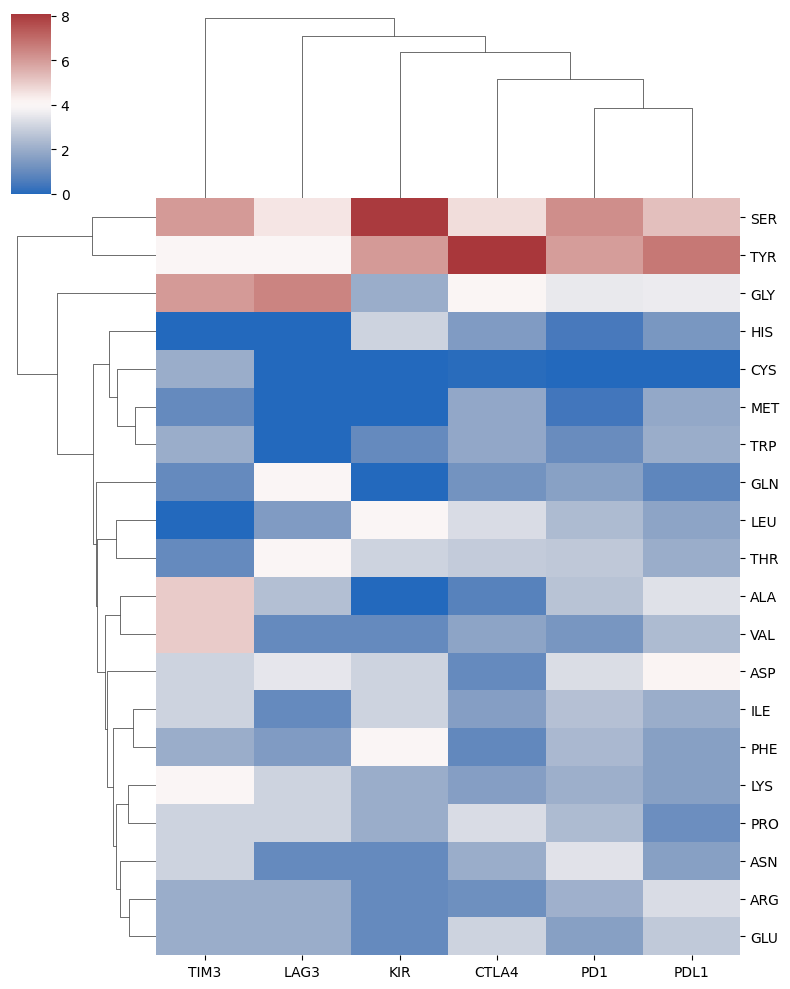

In [43]:
sns.clustermap(X.T,
               metric='euclidean',      # Abstandsmessung
               method='average',        # Cluster‑Methode („ward“, „complete“, …)
               cmap='vlag',             # Farbkarte für z‑Scores
               standard_scale=None,     # bereits z‑skaliert
               figsize=(8, 10))
plt.show()

<Axes: xlabel='PD1', ylabel='PDL1'>

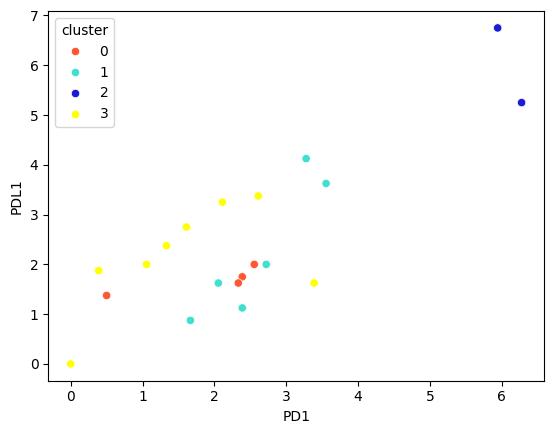

In [57]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(X.T)
df['cluster'] = kmeans.labels_
colors = ['#FF5733', '#40E0D0', "#1B1BD7", 'yellow']
sns.scatterplot(data=df, x='PD1', y='PDL1', hue='cluster', palette= colors)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df['cluster'] = kmeans.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PD1', y='PDL1', hue='cluster', palette='Set2', s=100, alpha=0.7)

# Annotation der Aminosäuren-Namen
for aa, row in df.iterrows():
    plt.text(row['PD1'] + 0.05, row['PDL1'] + 0.05, aa,
             fontsize=9, alpha=0.8)

plt.title('Aminosäuren nach PD1 vs PDL1 mit Cluster-Annotationen')
plt.xlabel('PD1 (z-score)')
plt.ylabel('PDL1 (z-score)')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()